In [1]:
import sys, os, os.path, time
import argparse
import numpy
import torch
import torch.nn as nn
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.autograd import Variable
from Net_mModal import Net, NewNet, TransformerEncoder, Transformer, MMTEncoder, LateFusion, videoModel, SuperLateFusion
from util_in_multi_h5_unnorm import *
from util_out import *
from util_f1 import *
from AudioResNet import resnet50
from AST import ASTModel

%matplotlib inline

import matplotlib.pyplot as plt


In [2]:
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    from tensorboardX import SummaryWriter
#from transformers import  AdamW, get_linear_schedule_with_warmup
torch.backends.cudnn.benchmark = True
from torch.optim.lr_scheduler import LambdaLR

In [3]:
torch.cuda.is_available()
torch.cuda.device_count()

2

In [4]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, last_epoch=-1):
    """
    Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, after
    a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
    Args:
        optimizer (:class:`~torch.optim.Optimizer`):
            The optimizer for which to schedule the learning rate.
        num_warmup_steps (:obj:`int`):
            The number of steps for the warmup phase.
        num_training_steps (:obj:`int`):
            The total number of training steps.
        last_epoch (:obj:`int`, `optional`, defaults to -1):
            The index of the last epoch when resuming training.
    Return:
        :obj:`torch.optim.lr_scheduler.LambdaLR` with the appropriate schedule.
    """

    def lr_lambda(current_step: int):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(
            0.0, float(num_training_steps - current_step) / float(max(1, num_training_steps - num_warmup_steps))
        )

    return LambdaLR(optimizer, lr_lambda, last_epoch)


# VICTIM MODEL

In [5]:
def mybool(s):
    return s.lower() in ['t', 'true', 'y', 'yes', '1']
parser = argparse.ArgumentParser()
parser.add_argument('--model_type', type = str, default = None, required=True)
parser.add_argument('--embedding_size', type = int, default = 1024) # this is the embedding size after a pooling layer
                                                                    # after a non-pooling layer, the embeddings size will be twice this much
parser.add_argument('--n_conv_layers', type = int, default = 10)
parser.add_argument('--n_trans_layers', type = int, default = 1)
parser.add_argument('--kernel_size', type = str, default = '3')     # 'n' or 'nxm'
parser.add_argument('--n_pool_layers', type = int, default = 5)     # the pooling layers will be inserted uniformly into the conv layers
                                                                    # the should be at least 2 and at most 6 pooling layers
                                                                    # the first two pooling layers will have stride (2,2); later ones will have stride (1,2)
parser.add_argument('--batch_norm', type = mybool, default = True)
parser.add_argument('--dropout', type = float, default = 0.0)
parser.add_argument('--pooling', type = str, default = 'lin', choices = ['max', 'ave', 'lin', 'exp', 'att', 'h-att', 'all'])
parser.add_argument('--batch_size', type = int, default = 250)
parser.add_argument('--ckpt_size', type = int, default = 1000)      # how many batches per checkpoint
parser.add_argument('--optimizer', type = str, default = 'adam', choices = ['adam', 'sgd', 'adamw'])
parser.add_argument('--init_lr', type = float, default = 1e-3)
parser.add_argument('--weight_decay', type = float, default = 0)
parser.add_argument('--beta1', type = float, default = 0.9)
parser.add_argument('--beta2', type = float, default = 0.999)
parser.add_argument('--lr_patience', type = int, default = 3)
parser.add_argument('--lr_factor', type = float, default = 0.8)
parser.add_argument('--max_ckpt', type = int, default = 30)
parser.add_argument('--random_seed', type = int, default = 15213)
parser.add_argument('--additional_outname', type = str, default = '')
parser.add_argument('--continue_from_ckpt', type = str, default = None)
parser.add_argument('--warmup_steps', type = int, default = 1000)
parser.add_argument('--gradient_accumulation', type = int, default = 1)
parser.add_argument('--scheduler', type = str, default = 'reduce', choices = ['reduce', 'warmup-decay'])
parser.add_argument('--addpos', type = mybool, default = False)
parser.add_argument('--transformer_dropout', type = float, default = 0.75)
parser.add_argument('--from_scratch', type = mybool, default = False)
parser.add_argument('--fusion_module', type = int, default = 0) # 0 for early fusion, 1 for mid fusion 1 
###MODEL INPUT PARAMS###
args = parser.parse_args(args=['--model_type=AST','--init_lr=4e-4','--fusion_module=0','--embedding_size=1024','--pooling=att','--n_trans_layers=2', '--batch_size=100', '--ckpt_size=2500', '--n_conv_layers=10', '--n_pool_layers=5', '--gradient_accumulation=3','--max_ckpt=7', '--scheduler=warmup-decay',
                              '--additional_outname=AST_debug'])



In [6]:
if 'x' not in args.kernel_size:
    args.kernel_size = args.kernel_size + 'x' + args.kernel_size

In [7]:
# Prepare log file and model directory
expid = '%s-embed%d-%dC%dP-kernel%s-%s-drop%.1f-%s-batch%d-ckpt%d-%s-lr%.0e-pat%d-fac%.1f-seed%d-Trans%d-weight-decay%.8f-betas%.3f-%.3f' % (
    args.model_type,
    args.embedding_size,
    args.n_conv_layers,
    args.n_pool_layers,
    args.kernel_size,
    'bn' if args.batch_norm else 'nobn',
    args.dropout,
    args.pooling,
    args.batch_size,
    args.ckpt_size,
    args.optimizer,
    args.init_lr,
    args.lr_patience,
    args.lr_factor,
    args.random_seed,
    args.n_trans_layers,
    args.weight_decay,
    args.beta1, 
    args.beta2
)

In [8]:
expid += args.additional_outname
WORKSPACE = os.path.join('/jet/home/billyli/data_folder/DayLongAudio/workspace/ICASSP2021_tune/', expid)
PRED_PATH = os.path.join(WORKSPACE, 'pred')
if not os.path.exists(PRED_PATH): os.makedirs(PRED_PATH)
EVAL_PATH = os.path.join(WORKSPACE, 'eval')
if not os.path.exists(EVAL_PATH): os.makedirs(EVAL_PATH)
if args.model_type=='TALNet':
    WORKSPACE = '../../workspace/ICASSP2021_tune/MMT-embed1024-10C5P-kernel3x3-bn-drop0.0-att-batch200-ckpt2500-adam-lr4e-04-pat3-fac0.8-seed15213-Trans2-weight-decay0.00000000-betas0.900-0.999early'
    PRED_PATH = os.path.join(WORKSPACE, 'pred')
    EVAL_PATH = os.path.join(WORKSPACE, 'eval')
    MODEL_FILE = os.path.join(WORKSPACE, 'model', 'checkpoint20.pt')
    PRED_FILE = os.path.join(PRED_PATH, 'checkpoint20.mat')
    EVAL_FILE = os.path.join(EVAL_PATH, 'checkpoint20.txt')
else:
    MODEL_FILE = os.path.join(WORKSPACE, 'model','checkpoint%d.pt' % args.max_ckpt)
    PRED_FILE = os.path.join(PRED_PATH, 'checkpoint%d.mat' % args.max_ckpt)
    EVAL_FILE = os.path.join(EVAL_PATH, 'checkpoint%d.txt' % args.max_ckpt)

In [9]:
args.kernel_size

'3x3'

In [10]:
print(args.model_type)
print(MODEL_FILE)

AST
/jet/home/billyli/data_folder/DayLongAudio/workspace/ICASSP2021_tune/AST-embed1024-10C5P-kernel3x3-bn-drop0.0-att-batch100-ckpt2500-adam-lr4e-04-pat3-fac0.8-seed15213-Trans2-weight-decay0.00000000-betas0.900-0.999AST_debug/model/checkpoint7.pt


In [11]:
# Load model
args.kernel_size = tuple(int(x) for x in args.kernel_size.split('x'))
#model = Net(args).cuda()
if args.model_type == 'TAL':
    model = Net(args).cuda()
elif args.model_type == 'TAL-trans':
    model = TransformerEncoder(args).cuda()
elif args.model_type == 'TAL-new':
    model = NewNet(args).cuda()
elif args.model_type == 'Trans':
    model = Transformer(args).cuda()
elif args.model_type == 'resnet':
    model = resnet50().cuda()
elif args.model_type == 'MMT':
    model = MMTEncoder(args).cuda()
elif args.model_type == 'VM':
    model = videoModel(args).cuda()
elif args.model_type == 'MMTLF':
    model = LateFusion(args).cuda()
elif args.model_type == 'AST':
    model = ASTModel(label_dim=527, input_fdim=64, input_tdim=400, imagenet_pretrain=False, audioset_pretrain=False).cuda()
else:
    print ('model type not recognized')
    exit(0)


---------------AST Model Summary---------------
ImageNet pretraining: False, AudioSet pretraining: False
inputshape:  64 400
outshape:  torch.Size([1, 768, 5, 39])
f_dim:  5 t_dim:  39
frequncey stride=10, time stride=10
number of patches=195
random pos_embedding shape:  torch.Size([1, 197, 768])


In [12]:
if args.optimizer == 'sgd':
    optimizer = SGD(model.parameters(), lr = args.init_lr, momentum = 0.9, nesterov = True)
elif args.optimizer == 'adam':
    optimizer = Adam(model.parameters(), lr = args.init_lr, betas=(args.beta1, args.beta2), weight_decay=args.weight_decay)
elif args.optimizer == 'adamw':
    optimizer = AdamW(model.parameters(), lr = args.init_lr, betas=(args.beta1, args.beta2), weight_decay=args.weight_decay)
if args.scheduler == 'reduce':
    scheduler = ReduceLROnPlateau(optimizer, mode = 'max', factor = args.lr_factor, patience = args.lr_patience) if args.lr_factor < 1.0 else None
elif args.scheduler == 'warmup-decay':
    t_total = args.ckpt_size * args.max_ckpt / args.gradient_accumulation
#     scheduler = WarmupLinearSchedule(optimizer, warmup_steps=args.warmup_steps, t_total=t_total) Deprecated API style
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args.warmup_steps, num_training_steps = t_total)

else:
    print ('scheduler type not recognized')
    exit(0)

In [13]:
prev_ckpt = torch.load(MODEL_FILE)
start_ckpt = prev_ckpt['epoch']
scheduler.load_state_dict(prev_ckpt['scheduler'])
# model = nn.DataParallel(model)
model.load_state_dict(prev_ckpt['model'])
optimizer.load_state_dict(prev_ckpt['optimizer'])
# write_log('Loading model from %s' % args.continue_from_ckpt)
model.eval()

ASTModel(
  (v): DistilledVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
      (1): Block(
        (norm1): LayerNorm((768

In [14]:
gas_valid_x1, gas_valid_x2, gas_valid_y, gas_eval_hashes = multi_bulk_load('GAS_valid')
gas_eval_x1, gas_eval_x2, gas_eval_y, gas_eval_hashes = multi_bulk_load('GAS_eval')

# data pipeline

In [14]:
gas_eval_x1, gas_eval_x2, gas_eval_y, gas_eval_hashes = multi_bulk_load('GAS_eval')

In [14]:
gas_eval_x1, gas_eval_y, gas_eval_hashes = bulk_load('GAS_eval')

In [15]:
gas_eval_x1.shape

(20123, 400, 64)

In [19]:
min_val = numpy.min(gas_eval_x1)

In [79]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    count = 0
    for i in range(400):
        if i % 40 == 0:
            count +=1
        if count % 2 == 0:
            record.mask[i] = True
    mask_record = record.compressed().reshape(200,64)
    fill_matrix = numpy.full((200,64), silence_val)
#     print('shape', fill_matrix.shape)
    mask_record = numpy.vstack((mask_record, fill_matrix))
#     record.mask[100:300]=True
#     mask_record = record[~record.mask]
#     print(mask_record.shape)
#     mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

In [38]:
new_gas_eval = []

for record in gas_eval_x1:
    record=numpy.ma.array(record,mask=False)
    silence_val = numpy.min(record)
    record.mask[100:300]=True
    mask_record = record.filled(fill_value=silence_val)
    new_gas_eval.append(mask_record)
new_gas_eval = numpy.array(new_gas_eval)

In [107]:
print(new_gas_eval[55][:100])

[[0.47305003 0.4076682  0.50134546 ... 0.6356075  0.683082   0.8488398 ]
 [0.37092775 0.36121237 0.3622962  ... 0.87717116 0.95238364 0.9700665 ]
 [0.48785508 0.43535295 0.39470476 ... 1.0653913  1.1007261  1.0363234 ]
 ...
 [0.79046273 0.68853074 0.8537748  ... 1.2209055  1.2898538  1.3113441 ]
 [0.550083   0.6614824  0.7878561  ... 1.195247   1.0824723  1.1018984 ]
 [0.37332636 0.5803106  0.7480199  ... 0.9628182  0.9976649  1.2168456 ]]


In [25]:
arr = new_gas_eval[255].T

In [26]:
print(arr.shape)

(64, 400)


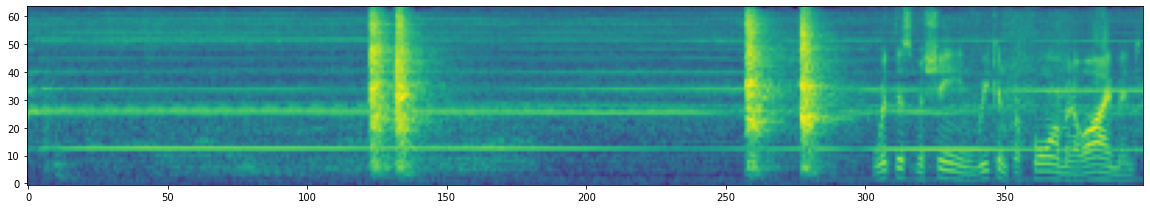

In [71]:

plt.figure(figsize = (20,10))
plt.imshow(gas_eval_x1[1].T, origin='lower')
plt.savefig('imgs/hammer.png')
# plt.imshow(arr,interpolation='nearest', aspect='auto')
# plt.gca().invert_yaxis()


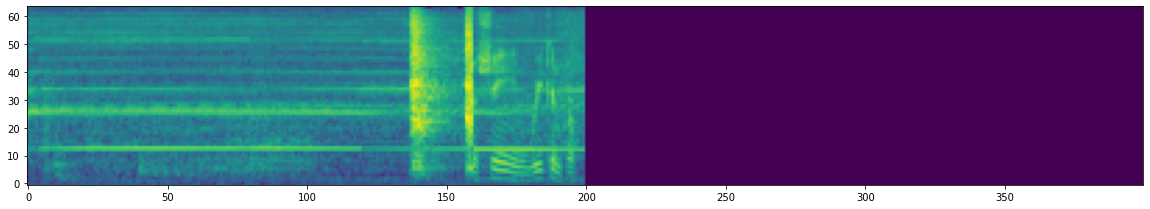

In [80]:
plt.figure(figsize = (20,10))

plt.imshow(new_gas_eval[1].T, origin='lower')
plt.savefig('imgs/0.5s-occlusion-concat.png')

In [40]:
arr=numpy.ma.array(arr,mask=False)
arr.mask[:200]=True

In [90]:
new_arr = arr.filled(fill_value=0)

In [91]:
print(new_arr[:200])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [16]:
gas_eval_global_prob_multi = model.predict(gas_eval_x1, verbose=False)

output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50, 527])
output shape: torch.Size([50

In [17]:
gas_eval_global_prob_multi = model.predict(new_gas_eval, verbose=False)

NameError: name 'new_gas_eval' is not defined

In [18]:
print(gas_eval_global_prob_multi.shape)

(20123, 527)


In [19]:
print('Performance on Google Audio Set:')
print("   CLASS ||    AP |   AUC |    d' ")
FORMAT  = ' %00007s || %5.3f | %5.3f |%6.03f '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)

Performance on Google Audio Set:
   CLASS ||    AP |   AUC |    d' 
---------++-------+-------+-------


In [20]:
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob_multi[0].shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob_multi[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
# for c in classwise_dict:
#     print(c)
print(FORMAT % ('Average', map, mauc, dprime(mauc)))
print(SEP)
for i in range(N_CLASSES):
    print(FORMAT % ((str(i),) + classwise[i]))

0.02505825692258454 0.09024525531095988 -1.8939802528041405
 Average || 0.025 | 0.090 |-1.894 
---------++-------+-------+-------
       0 || 0.366 | 0.195 |-1.218 
       1 || 0.020 | 0.051 |-2.318 
       2 || 0.023 | 0.014 |-3.126 
       3 || 0.063 | 0.082 |-1.967 
       4 || 0.018 | 0.015 |-3.060 
       5 || 0.019 | 0.053 |-2.284 
       6 || 0.018 | 0.115 |-1.696 
       7 || 0.018 | 0.061 |-2.186 
       8 || 0.018 | 0.102 |-1.794 
       9 || 0.018 | 0.140 |-1.528 
      10 || 0.018 | 0.139 |-1.532 
      11 || 0.018 | 0.022 |-2.848 
      12 || 0.020 | 0.223 |-1.076 
      13 || 0.020 | 0.081 |-1.975 
      14 || 0.019 | 0.095 |-1.856 
      15 || 0.019 | 0.048 |-2.361 
      16 || 0.038 | 0.071 |-2.073 
      17 || 0.020 | 0.049 |-2.343 
      18 || 0.019 | 0.022 |-2.848 
      19 || 0.019 | 0.022 |-2.837 
      20 || 0.019 | 0.018 |-2.964 
      21 || 0.018 | 0.047 |-2.369 
      22 || 0.019 | 0.115 |-1.697 
      23 || 0.018 | 0.057 |-2.233 
      24 || 0.019 | 0.114 |-1.

In [63]:
import matplotlib.pyplot as plt


<Figure size 28800x7200 with 0 Axes>

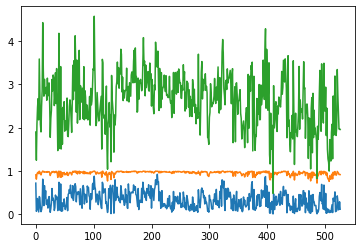

<Figure size 28800x7200 with 0 Axes>

In [64]:
plt.plot(classwise)
plt.figure(figsize=(400,100)) 


# Adversarial Routine

In [ ]:
for batch in range(1, args.ckpt_size + 1):
        x, y = next(train_gen)
        global_prob = model(x)[0]
        global_prob.clamp_(min = 1e-7, max = 1 - 1e-7)
        loss = criterion(global_prob, y)
        if args.gradient_accumulation > 1:
            loss = loss / args.gradient_accumulation
        #if n_gpu > 1:
        #    loss = loss.mean()
        train_loss += loss.item()
        if numpy.isnan(train_loss) or numpy.isinf(train_loss): break
        loss.backward()
        global_step += 1
        if global_step % args.gradient_accumulation == 0:
            optimizer.step()
            if args.scheduler == 'warmup-decay':
                scheduler.step() 
            optimizer.zero_grad()
        if batch % 500 == 0:
            sys.stderr.write('Checkpoint %d, Batch %d / %d, avg train loss = %f\r' % \
                            (checkpoint, batch, args.ckpt_size, train_loss / batch))
            tb_writer.add_scalar('lr', optimizer.param_groups[0]['lr'], global_step)
            tb_writer.add_scalar('loss', train_loss / batch, global_step)
            
        del x, y, global_prob, loss         # This line and next line: to save GPU memory
        torch.cuda.empty_cache()            # I don't know if they're useful or not
    train_loss /= args.ckpt_size


In [ ]:
def train(opt, model, adv_jam, trainloader, max_batches = 100):
    model.eval()
        
    batches = 0
    total = 0
    error = 0
    loss_ = 0.
    torch.manual_seed(0)

    for X_batch, y_batch in trainloader:
        # forward pass
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        # plot(X_batch[0], y_batch[0])
        output = model(adv_jam(X))
        opt.zero_grad()
        neg_loss = -nn.CrossEntropyLoss()(output, y)

        neg_loss.backward()
        opt.step()



        # Evaluate performance
        adv_out = model(X_adv)
        adv_prediction = sigmoid(adv_out.squeeze().cpu().detach())>0.5
        adv_accuracy = (adv_prediction.numpy()==y_batch.cpu().numpy()).mean()
        print("Accuracy = {0}".format(adv_accuracy))
                # project into feasible region
        adv.jam.param1.clamp_(0,1)
        adv.jam.param2.clamp_(1, 40)
        adv.jam.param3.clamp_(0,224)
        total += X.shape[0]
        error += (output.max(1)[1] != y).sum().item()
        loss_ += nn.CrossEntropyLoss(size_average=False)(output, y).item()
            batches += 1
            if batches > max_batches:
                break

        return error / total, loss_ / total

In [1]:
def projected_gradient_descent(model, x, y, num_steps = 20, step_size = 0.1, step_norm=2, eps = 10, eps_norm=2,
                               clamp=(x_min, x_max), y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    x_adv = x.clone().detach().requires_grad_(True)#.to(x.device)
    N, T, V = x.shape
    targeted = y_target is not None
    num_channels = x.shape[1]
    criterion = nn.BCELoss()

    for i in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)
        
        out = model(_x_adv) # N x T x 1
        out_flatten = out.reshape(-1) 
        y_flatten = y.reshape(-1)
        loss = criterion(out_flatten, y_flatten)
        
        #prediction = model(_x_adv)
        #loss = criterion(prediction, y_target if targeted else y)
        loss.backward()

        with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
            if step_norm == 'inf':
                gradients = _x_adv.grad.sign() * step_size
            else:
                # The grad is normalized here.
                #gradients = _x_adv.grad 
                # Only normalize w.r.t. to feats at a timestep
                gradients = _x_adv.grad/_x_adv.grad.norm(step_norm, dim=-1).view(-1, T, 1)
                gradients *= step_size
                
            if targeted:
                # Targeted: Gradient descent with on the loss of the (incorrect) target label
                # w.r.t. the image data
                x_adv -= gradients
            else:
                # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                # the model parameters
                x_adv += gradients

        # Project back into l_norm ball and correct range
        if eps_norm == 'inf':
            # Workaround as PyTorch doesn't have elementwise clip
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
        else:
            delta = x_adv - x

            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            mask = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1) <= eps

            scaling_factor = delta.view(delta.shape[0], T, -1).norm(eps_norm, dim=-1)
            scaling_factor[mask] = eps
            #print(scaling_factor.shape)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / scaling_factor.view(-1, T, 1)

            x_adv = x + delta
            
        x_adv = x_adv.clamp(*clamp)

    return x_adv.detach()

NameError: name 'x_min' is not defined